In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
import time

!pip install facenet_pytorch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
import torch.utils
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
from facenet_pytorch import InceptionResnetV1
import torchvision.models as models

You are using pip version 19.0.3, however version 19.2.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [4]:
PATH_TRAIN='/kaggle/input/preproces_images/'
batch_size = 32
HIDDEN_SIZE=1000
ind = np.array(list(range(len(os.listdir(PATH_TRAIN)))))
np.random.shuffle(ind)
sample_train=dict(zip(list(range(int(len(ind)*0.8))),np.array(os.listdir(PATH_TRAIN))[ind[:int(len(ind)*0.8)]]))
sample_test=dict(zip(list(range(int(len(ind)*0.2))),np.array(os.listdir(PATH_TRAIN))[ind[int(len(ind)*0.8):]]))


FileNotFoundError: [WinError 3] The system cannot find the path specified: '/kaggle/input/preproces_images/'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DetectionDataset(torch.utils.data.Dataset):
    
    def __init__(self, sample):
        self.sample=sample        
    def __len__(self):
        return len(self.sample)
    
    def __getitem__(self, idx):
        img = cv2.imread(PATH_TRAIN+self.sample[idx])[:,:,::-1]
        img = DetectionDataset.preprocess_img(img)
        rate=torch.tensor(-1)
        #rate=labels[labels.names==self.sample[idx]]['rate'].values[0]
        return img,rate
    
    @staticmethod
    def preprocess_img(img, dsize=(350,350)):
        img = cv2.resize(img, dsize)
        img = img.astype(np.float32)
        img =(img-127.5)/127.5
        img = np.moveaxis(img, -1, 0)
        return torch.Tensor(img)

In [ ]:
dataset = DetectionDataset(sample=sample_train)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=0, drop_last=True)

In [ ]:
datasett = DetectionDataset(sample=sample_test)
testloader = torch.utils.data.DataLoader(datasett, batch_size=batch_size,
                                          shuffle=True, num_workers=0, drop_last=True)

In [5]:
device =torch.device("cuda" if torch.cuda.is_available() else "cpu")
class Net(nn.Module):
    def __init__(self,hidden_size):
        super(Net, self).__init__()
        self.extr =  nn.Sequential(*list(InceptionResnetV1(pretrained='vggface2').children())[:14])
        self.hidden_size=hidden_size
        self.linear1 =nn.Linear(1792,1000)
        self.dropout=nn.Dropout(0.1)
        self.batch_norm1=nn.BatchNorm1d(1000)

        self.linear_mean=nn.Linear(1000,hidden_size)
        self.batch_norm_mean=nn.BatchNorm1d(hidden_size)
        self.linear_cov=nn.Linear(1000,hidden_size)
        self.batch_norm_out=nn.BatchNorm1d(hidden_size)

        self.linear_decoder2=nn.Linear(hidden_size,512*15*15)
        self.batch_norm_d2=nn.BatchNorm1d(512*15*15)
        self.conv_t_0 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, padding=0, stride=2)
        self.conv_b_0 = nn.BatchNorm2d(256)
        self.conv_t_1 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, padding=1, stride=3)
        self.conv_b_1 = nn.BatchNorm2d(128)
        self.conv_t_2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, padding=1, stride=1)
        self.conv_b_2 = nn.BatchNorm2d(64)
        self.conv_t_3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, padding=3, stride=2)
        self.conv_b_3 = nn.BatchNorm2d(32)
        self.conv_t_4 = nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=2, padding=2, stride=2)
        

        #self.conv_b_4 = nn.BatchNorm2d(8)
        #self.conv_t_5 = nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=3, padding=0, stride=1)
    def forward(self, x):
        
        x = self.extr(x)
        x=x.view(-1,1792)

        x=self.batch_norm1(self.dropout(F.relu(self.linear1(x))))
        mean=self.batch_norm_mean(self.dropout(self.linear_mean(x)))
        cov = 0.5*self.linear_cov(x)
        x=self.batch_norm_out(mean+torch.exp(cov)*(torch.FloatTensor(self.hidden_size).normal_().to(device)))
        return self.decoder(x),mean,cov
    def change_derivative(self,where):
        i=0
        for param in self.extr.parameters():
            i+=1
            if i>=where:
                param.requires_grad = True  
            else:
                param.requires_grad = False
    def decoder(self,x):
        x=self.batch_norm_d2(F.leaky_relu(self.linear_decoder2(x)))
        x=x.view(-1,512,15,15)
        x=self.conv_b_0(F.leaky_relu(self.conv_t_0(x)))
        x=self.conv_b_1(F.leaky_relu(self.conv_t_1(x)))
        x=self.conv_b_2(F.leaky_relu(self.conv_t_2(x)))
        x=self.conv_b_3(F.leaky_relu(self.conv_t_3(x)))
        #x=self.conv_b_4(F.leaky_relu(self.conv_t_4(x)))
        x=self.conv_t_4(x)
        x = torch.tanh(x)
        return x
net = Net(1000)
net.change_derivative(100)
net.to(device)

Net(
  (extr): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (2): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (5

In [ ]:
def loss_function(recon_x, x, mu, logvar):
    BCE = torch.mean((recon_x - x)**2)

    KLD = -0.5 * torch.mean(torch.mean(1 + logvar - mu.pow(2) - logvar.exp(), 1))
    return BCE+KLD * 3

In [ ]:
criterion = loss_function
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [ ]:
train_loss=[]
test_loss=[]

In [ ]:
for e in range(1,3):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 1):
        inputs = data[0].to(device)
        labels=inputs.clone()
        #labels = labels.to(device)

        optimizer.zero_grad()
        outputs,mean,cov = net(inputs)
            
        loss = criterion(outputs, labels,mean,cov)
        loss.backward()
        optimizer.step()


        running_loss += loss.item()
    train_loss.append(running_loss / i)
    running_loss = 0.0
    for i, data in enumerate(testloader, 1):
        inputs = data[0]
        inputs = inputs.to(device)
        labels = inputs.clone().to(device)

        outputs,mean,cov = net(inputs)
 
        loss = criterion(outputs, labels,mean,cov)
        loss.backward()
        
        running_loss += loss.item()
    test_loss.append(running_loss / i)
    if e%15==0:
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr']/2
    print(e,'Train',train_loss[-1],"Test ",test_loss[-1])

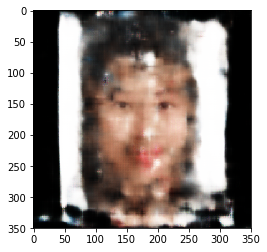

In [23]:
plt.imshow(np.array(net.decoder(torch.FloatTensor(5,HIDDEN_SIZE).normal_())[3].cpu().detach().permute(1,2,0)*127.5+127.5,dtype=int))

In [ ]:
net.change_derivative(11)

In [ ]:
torch.save(net.state_dict(), 'vae_fromclassificator')

In [7]:
net.load_state_dict(torch.load('vae_fromclassificator',map_location='cpu'))

In [ ]:
from IPython.display import FileLink
FileLink('vae_fromclassificator')

In [ ]:
np.savetxt('trainn.txt',train_loss)
np.savetxt('testt.txt',train_loss)

In [ ]:
from IPython.display import FileLink
FileLink('testt.txt')